In [0]:
from pandas import read_csv
import numpy as np

In [3]:
from tensorflow.test import gpu_device_name
gpu_device_name()

'/device:GPU:0'

In [0]:
oo=read_csv('FINALFINALREVIEW.csv')

In [5]:
oo.head()

,Unnamed: 0,Summary,Text
0,0,<alpha> good quality dog food <omega>,i have bought several of the vitality canned d...
1,1,<alpha> not as advertised <omega>,product arrived labeled as jumbo salted peanut...
2,2,<alpha> delight says it all <omega>,this is a confection that has been around a fe...
3,3,<alpha> cough medicine <omega>,if you are looking for the secret ingredient i...
4,4,<alpha> great taffy <omega>,great taffy at a great price there was a wide ...


In [0]:
oo=oo.drop(labels=['Unnamed: 0'],axis=1)

In [7]:
oo.head()

,Summary,Text
0,<alpha> good quality dog food <omega>,i have bought several of the vitality canned d...
1,<alpha> not as advertised <omega>,product arrived labeled as jumbo salted peanut...
2,<alpha> delight says it all <omega>,this is a confection that has been around a fe...
3,<alpha> cough medicine <omega>,if you are looking for the secret ingredient i...
4,<alpha> great taffy <omega>,great taffy at a great price there was a wide ...


In [0]:
oo.Summary=oo.Summary.apply(lambda x: str(x))
oo.Text=oo.Text.apply(lambda x: str(x))

In [0]:
oo['text_length']=oo.Text.apply(lambda x: len(x))

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


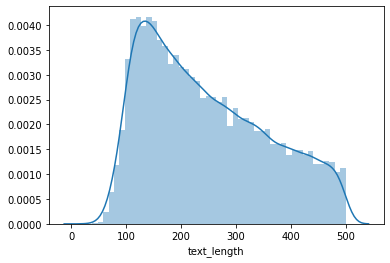

In [10]:
import seaborn as sns
sns.distplot(oo[oo.text_length<=500].text_length)

In [0]:
oo=oo[oo.text_length<=500]

In [12]:
oo.head()

,Summary,Text,text_length
0,<alpha> good quality dog food <omega>,i have bought several of the vitality canned d...,259
1,<alpha> not as advertised <omega>,product arrived labeled as jumbo salted peanut...,184
2,<alpha> delight says it all <omega>,this is a confection that has been around a fe...,485
3,<alpha> cough medicine <omega>,if you are looking for the secret ingredient i...,212
4,<alpha> great taffy <omega>,great taffy at a great price there was a wide ...,132


In [13]:
x_maxlen=max([len(s) for s in oo.Text])
x_maxlen

500

In [14]:
y_maxlen=max([len(s) for s in oo.Summary])
y_maxlen

141

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_tokenizer=Tokenizer()
x_tokenizer.fit_on_texts(oo.Text)
X=x_tokenizer.texts_to_sequences(oo.Text)
X=pad_sequences(X,maxlen=x_maxlen,padding='post')

y_tokenizer=Tokenizer()
y_tokenizer.fit_on_texts(oo.Summary)
y=y_tokenizer.texts_to_sequences(oo.Summary)
y=pad_sequences(y,maxlen=y_maxlen,padding='post')

In [16]:
X.shape

(45846, 500)

In [17]:
y.shape

(45846, 141)

In [0]:
from tensorflow.keras.layers import Input,Embedding,LSTM,Concatenate,TimeDistributed,Dense
from tensorflow.keras.models import Model

In [0]:
from attention import AttentionLayer

In [22]:
latent_dim=500
x_voc_size=len(x_tokenizer.word_index)
y_voc_size=len(y_tokenizer.word_index)
# Encoder 
encoder_inputs = Input(shape=(x_maxlen,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 500)     13785000    input_2[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
model.compile('rmsprop',loss='sparse_categorical_crossentropy')

In [0]:
encoder_input=X
decoder_input=y[:,:-1]
decoder_target=y.reshape(y.shape[0],y.shape[1],1)[:,1:]
epochs=50

In [25]:
decoder_input.shape

(45846, 140)

In [26]:
decoder_target.shape

(45846, 140, 1)

In [31]:
history=model.fit([encoder_input[:10000],decoder_input[:10000]],decoder_target[:10000],epochs=5)

Epoch 1/5
313/313 [==============================] - 371s 1s/step - loss: 0.1487
Epoch 2/5
313/313 [==============================] - 372s 1s/step - loss: 0.1386
Epoch 3/5
313/313 [==============================] - 371s 1s/step - loss: 0.1303
Epoch 4/5
313/313 [==============================] - 373s 1s/step - loss: 0.1224
Epoch 5/5
313/313 [==============================] - 374s 1s/step - loss: 0.1146


In [0]:
max_len_text=500
max_len_summary=140
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))
dec_emb2= dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])
decoder_outputs2 = decoder_dense(decoder_inf_concat)
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [0]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    target_seq[0, 0] = target_word_index['alpha']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])


        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='omega'):
            decoded_sentence += ' '+sampled_token
            if len(decoded_sentence)>=max_len_summary:
              stop_condition=True
        else:
          stop_condition=True

        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        e_h, e_c = h, c

    return decoded_sentence

In [0]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['alpha']) and i!=target_word_index['omega']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [74]:
for i in range(len(X)):
  print("Review:",seq2text(X[i]))
  print("Original summary:",seq2summary(y[i]))
  print("Predicted summary:",decode_sequence(X[i].reshape(1,max_len_text)))
  print("\n")

Review: i have bought several of the vitality canned dog food products and have found them all to be of good quality the product looks more like a stew than a processed meat and it smells better my labrador is finicky and she appreciates this product better than most 
Original summary: good quality dog food 
Predicted summary:  great dog food


Review: product arrived labeled as jumbo salted peanuts the peanuts were actually small sized unsalted not sure if this was an error or if the vendor intended to represent the product as jumbo 
Original summary: not as advertised 
Predicted summary:  not as good as other canned s


Review: this is a confection that has been around a few centuries it is a light pillowy citrus gelatin with nuts in this case filberts and it is cut into tiny squares and then liberally coated with powdered sugar and it is a tiny mouthful of heaven not too chewy and very flavorful i highly recommend this yummy treat if you are familiar with the story of c s lewis the 

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Predicted summary:  great candy


Review: i have lived out of the us for over yrs now and i so miss my twizzlers when i go back to visit or someone visits me i always stock up all i can say is yum br sell these in mexico and you will have a faithful buyer more often than i m able to buy them right now 
Original summary: please sell these in mexico 
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-74-4b9650bb7d1b>", line 4, in <module>
    print("Predicted summary:",decode_sequence(X[i].reshape(1,max_len_text)))
  File "<ipython-input-71-5993b93d3bd3>", line 14, in decode_sequence
    output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 88, in _method_wrapper
    return method(self, *args, **kwargs)
  

KeyboardInterrupt: ignored

In [0]:
reverse_target_word_index=y_tokenizer.index_word

In [69]:
reverse_target_word_index[0]

'omega'